Este documento detalha os resultados obtidos através da aplicação do algoritmo `SAC_DM` sobre sinais de geradores de energia eólica. Em um primeiro momento, foi aplicado o SAC_DM sobre o sinal `original`. Já no segundo momento, uma etapa extra foi executada, o sinal foi passado por um filtro `wavelet` antes de ser aplicado ao SAC_DM.

In [1]:
import pywt
import numpy as np

from scipy import signal, stats
from scipy.stats import skew, kurtosis
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import scipy.io as sio

from decimal import Decimal

import sys

from scipy.interpolate import spline

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [2]:
pywt.families(short=False)

['Haar',
 'Daubechies',
 'Symlets',
 'Coiflets',
 'Biorthogonal',
 'Reverse biorthogonal',
 'Discrete Meyer (FIR Approximation)',
 'Gaussian',
 'Mexican hat wavelet',
 'Morlet wavelet',
 'Complex Gaussian wavelets',
 'Shannon wavelets',
 'Frequency B-Spline wavelets',
 'Complex Morlet wavelets']

In [3]:
def upload_signal_np(filename):
    data = np.genfromtxt(filename, delimiter=' ', names=['x', 'y'])
    return data

In [4]:
def upload_signal(filename):
    data = sio.loadmat(filename)
    x_struct = data['tempo']
    y_struct = data['Is']
    data = {'x':[], 'y':[]}
    for i in range(len(y_struct)):
        data['x'].append(x_struct[i, 0])
        data['y'].append(y_struct[i, 0])
    return data

In [5]:
def sac_dm(data, GROUP_SIZE):

	threshold = 0.0

	DATASET_SIZE = len(data['y'])

	rho = 0.0

	GROUP_AMOUNT = 1 + int(DATASET_SIZE)/GROUP_SIZE
	sacdm=[] #* int(GROUP_AMOUNT)


	up = 0
	peaks = 0
	i = 1
	n = GROUP_SIZE
	j = 0
    
	# check if the first point is a peak
	if data['y'][0] > data['y'][1]:
		peaks += 1
	# check if the last point is a peak
	if data['y'][-1] > data['y'][-2]:
		peaks += 1

	while i < DATASET_SIZE-2:
		a = data['y'][i]
		b = data['y'][i+1]
		c = data['y'][i+2]

		if b > (a+threshold) and b > (c+threshold):
			peaks = peaks + 1
			
		if i%n == 0:
			rho = peaks/float(GROUP_SIZE)

			if rho != 0:
				# sacdm[j] = rho 
				sacdm.append(1/(6*rho))
			else:
				print('i = ',i, ' peaks = ', peaks)
				sacdm.append(0)
			j = j + 1
# 			n = n + GROUP_SIZE
			peaks = 0
		i = i+1

	avg = sum(sacdm)/len(sacdm)
	print("sacdm min: ", min(sacdm), ", sacdm max: ", max(sacdm))
	print("Average: ", avg)
	return sacdm, avg

In [6]:
def mean_var_pder(signal):
    return '%.3f  %.3e  %.3f' % (np.mean(signal), np.var(signal), np.std(signal))


# Tipos de Defeitos

Defeito 1 (**D1**) – curto-circuito entre espiras

Defeito 2 (**D2**) – curto-circuito espira-terra (espira-carcaça)

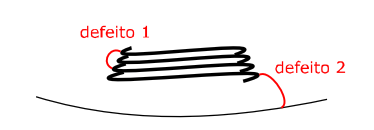

In [7]:
from IPython.display import Image, display

#Read image
display(Image(filename = "defeitos.png"))


# Upload dos sinais

In [8]:
data_on = upload_signal("dados/C100_F5k_ON.mat") #Sem defeito

data_d1_p1_r1 = upload_signal("dados/C100_F5k_D1_P1_R1.mat")
data_d2_p1_r1 = upload_signal("dados/C100_F5k_D2_P1_R1.mat")

data_d1_p1_r2 = upload_signal("dados/C100_F5k_D1_P1_R2.mat")
data_d2_p1_r2 = upload_signal("dados/C100_F5k_D2_P1_R2.mat")

data_d1_p2_r1 = upload_signal("dados/C100_F5k_D1_P2_R1.mat")
data_d2_p2_r1 = upload_signal("dados/C100_F5k_D2_P2_R1.mat")

data_d1_p2_r2 = upload_signal("dados/C100_F5k_D1_P2_R2.mat")
data_d2_p2_r2 = upload_signal("dados/C100_F5k_D2_P2_R2.mat")

data_d1_p3_r1 = upload_signal("dados/C100_F5k_D1_P3_R1.mat")
data_d2_p3_r1 = upload_signal("dados/C100_F5k_D2_P3_R1.mat")

data_d1_p3_r2 = upload_signal("dados/C100_F5k_D1_P3_R2.mat")
data_d2_p3_r2 = upload_signal("dados/C100_F5k_D2_P3_R2.mat")

data_d1_p4_r1 = upload_signal("dados/C100_F5k_D1_P4_R1.mat")
data_d2_p4_r1 = upload_signal("dados/C100_F5k_D2_P4_R1.mat")

data_d1_p4_r2 = upload_signal("dados/C100_F5k_D1_P4_R2.mat")
data_d2_p4_r2 = upload_signal("dados/C100_F5k_D2_P4_R2.mat")

data_d1_p5_r1 = upload_signal("dados/C100_F5k_D1_P5_R1.mat")
data_d2_p5_r1 = upload_signal("dados/C100_F5k_D2_P5_R1.mat")

data_d1_p5_r2 = upload_signal("dados/C100_F5k_D1_P5_R2.mat")
data_d2_p5_r2 = upload_signal("dados/C100_F5k_D2_P5_R2.mat")

data_d1_p6_r1 = upload_signal("dados/C100_F5k_D1_P6_R1.mat")
data_d2_p6_r1 = upload_signal("dados/C100_F5k_D2_P6_R1.mat")

data_d1_p6_r2 = upload_signal("dados/C100_F5k_D1_P6_R2.mat")
data_d2_p6_r2 = upload_signal("dados/C100_F5k_D2_P6_R2.mat")

data_d1_p7_r1 = upload_signal("dados/C100_F5k_D1_P7_R1.mat")
data_d2_p7_r1 = upload_signal("dados/C100_F5k_D2_P7_R1.mat")

data_d1_p7_r2 = upload_signal("dados/C100_F5k_D1_P7_R2.mat")
data_d2_p7_r2 = upload_signal("dados/C100_F5k_D2_P7_R2.mat")

data_d1_p8_r1 = upload_signal("dados/C100_F5k_D1_P8_R1.mat")
data_d2_p8_r1 = upload_signal("dados/C100_F5k_D2_P8_R1.mat")

data_d1_p8_r2 = upload_signal("dados/C100_F5k_D1_P8_R2.mat")
data_d2_p8_r2 = upload_signal("dados/C100_F5k_D2_P8_R2.mat")

data_d1_p9_r1 = upload_signal("dados/C100_F5k_D1_P9_R1.mat")
data_d2_p9_r1 = upload_signal("dados/C100_F5k_D2_P9_R1.mat")

data_d1_p9_r2 = upload_signal("dados/C100_F5k_D1_P9_R2.mat")
data_d2_p9_r2 = upload_signal("dados/C100_F5k_D2_P9_R2.mat")

data_d1_p10_r1 = upload_signal("dados/C100_F5k_D1_P10_R1.mat")
data_d2_p10_r1 = upload_signal("dados/C100_F5k_D2_P10_R1.mat")

data_d1_p10_r2 = upload_signal("dados/C100_F5k_D1_P10_R2.mat")
data_d2_p10_r2 = upload_signal("dados/C100_F5k_D2_P10_R2.mat")


In [9]:
len(data_d1_p10_r1['y'])

1000001

# Aplicação do SAC_DM

In [10]:
GROUP_SIZE = 1000
avg_amount = []

print("ON")
#ON
sac_on, avg = sac_dm(data_on, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P1_R1")
#D1_P1_R1
sac_d1_p1_r1, avg = sac_dm(data_d1_p1_r1, GROUP_SIZE)
avg_amount.append(avg)
avg_d1 = avg
#D2_P1_R1
sac_d2_p1_r1, avg = sac_dm(data_d2_p1_r1, GROUP_SIZE)
avg_amount.append(avg)
avg_d2 = avg
print("\n")

print("P1_R2")
#D1_P1_R2
sac_d1_p1_r2, avg = sac_dm(data_d1_p1_r2, GROUP_SIZE)
avg_amount.append(avg)
#D2_P1_R2
sac_d2_p1_r2, avg = sac_dm(data_d2_p1_r2, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P2_R1")
#D1_P2_R1
sac_d1_p2_r1, avg = sac_dm(data_d1_p2_r1, GROUP_SIZE)
avg_amount.append(avg)
#D2_P2_R1
sac_d2_p2_r1, avg = sac_dm(data_d2_p2_r1, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P2_R2")
#D1_P2_R2
sac_d1_p2_r2, avg = sac_dm(data_d1_p2_r2, GROUP_SIZE)
avg_amount.append(avg)
#D2_P2_R2
sac_d2_p2_r2, avg = sac_dm(data_d2_p2_r2, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P3_R1")
#D1_P3_R1
sac_d1_p3_r1, avg = sac_dm(data_d1_p3_r1, GROUP_SIZE)
avg_amount.append(avg)
#D2_P3_R1
sac_d2_p3_r1, avg = sac_dm(data_d2_p3_r1, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P3_R2")
#D1_P3_R2
sac_d1_p3_r2, avg = sac_dm(data_d1_p3_r2, GROUP_SIZE)
avg_amount.append(avg)
#D2_P3_R2
sac_d2_p3_r2, avg = sac_dm(data_d2_p3_r2, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P4_R1")
#D1_P4_R1
sac_d1_p4_r1, avg = sac_dm(data_d1_p4_r1, GROUP_SIZE)
avg_amount.append(avg)
#D2_P4_R1
sac_d2_p4_r1, avg = sac_dm(data_d2_p4_r1, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P4_R2")
#D1_P4_R2
sac_d1_p4_r2, avg = sac_dm(data_d1_p4_r2, GROUP_SIZE)
avg_amount.append(avg)
#D2_P4_R2
sac_d2_p4_r2, avg = sac_dm(data_d2_p4_r2, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P5_R1")
#D1_P5_R1
sac_d1_p5_r1, avg = sac_dm(data_d1_p5_r1, GROUP_SIZE)
avg_amount.append(avg)
#D2_P5_R1
sac_d2_p5_r1, avg = sac_dm(data_d2_p5_r1, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P5_R2")
#D1_P5_R2
sac_d1_p5_r2, avg = sac_dm(data_d1_p5_r2, GROUP_SIZE)
avg_amount.append(avg)
#D2_P5_R2
sac_d2_p5_r2, avg = sac_dm(data_d2_p5_r2, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P6_R1")
#D1_P6_R1
sac_d1_p6_r1, avg = sac_dm(data_d1_p6_r1, GROUP_SIZE)
avg_amount.append(avg)
#D2_P6_R1
sac_d2_p6_r1, avg = sac_dm(data_d2_p6_r1, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P6_R2")
#D1_P6_R2
sac_d1_p6_r2, avg = sac_dm(data_d1_p6_r2, GROUP_SIZE)
avg_amount.append(avg)
#D2_P6_R2
sac_d2_p6_r2, avg = sac_dm(data_d2_p6_r2, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P7_R1")
#D1_P7_R1
sac_d1_p7_r1, avg = sac_dm(data_d1_p7_r1, GROUP_SIZE)
avg_amount.append(avg)
#D2_P7_R1
sac_d2_p7_r1, avg = sac_dm(data_d2_p7_r1, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P7_R2")
#D1_P7_R2
sac_d1_p7_r2, avg = sac_dm(data_d1_p7_r2, GROUP_SIZE)
avg_amount.append(avg)
#D2_P2_R2
sac_d2_p7_r2, avg = sac_dm(data_d2_p7_r2, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P8_R1")
#D1_P8_R1
sac_d1_p8_r1, avg = sac_dm(data_d1_p8_r1, GROUP_SIZE)
avg_amount.append(avg)
#D2_P8_R1
sac_d2_p8_r1, avg = sac_dm(data_d2_p8_r1, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P8_R2")
#D1_P8_R2
sac_d1_p8_r2, avg = sac_dm(data_d1_p8_r2, GROUP_SIZE)
avg_amount.append(avg)
#D2_P8_R2
sac_d2_p8_r2, avg = sac_dm(data_d2_p8_r2, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P9_R1")
#D1_P9_R1
sac_d1_p9_r1, avg = sac_dm(data_d1_p9_r1, GROUP_SIZE)
avg_amount.append(avg)
#D2_P9_R1
sac_d2_p9_r1, avg = sac_dm(data_d2_p9_r1, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P9_R2")
#D1_P9_R2
sac_d1_p9_r2, avg = sac_dm(data_d1_p9_r2, GROUP_SIZE)
avg_amount.append(avg)
#D2_P9_R2
sac_d2_p9_r2, avg = sac_dm(data_d2_p9_r2, GROUP_SIZE)
avg_amount.append(avg)
print("\n")

print("P10_R1")
#D1_P10_R1
sac_d1_p10_r1, avg = sac_dm(data_d1_p10_r1, GROUP_SIZE)
avg_amount.append(avg)
#D2_P10_R1
sac_d2_p10_r1, avg = sac_dm(data_d2_p10_r1, GROUP_SIZE)
avg_amount.append(avg)
print("\n")
from numpy import mean, var

print("P10_R2")
#D1_P10_R2
sac_d1_p10_r2, avg = sac_dm(data_d1_p10_r2, GROUP_SIZE)
avg_amount.append(avg)
#D2_P10_R2
sac_d2_p10_r2, avg = sac_dm(data_d2_p10_r2, GROUP_SIZE)
avg_amount.append(avg)

ON
sacdm min:  3.2051282051282053 , sacdm max:  3.875968992248062
Average:  3.3185574819127894


P1_R1
sacdm min:  2.2522522522522523 , sacdm max:  2.73224043715847
Average:  2.395643600494725
sacdm min:  2.2522522522522523 , sacdm max:  2.73224043715847
Average:  2.3963532155651626


P1_R2
sacdm min:  2.192982456140351 , sacdm max:  2.6455026455026456
Average:  2.3115999275089236
sacdm min:  2.192982456140351 , sacdm max:  2.6455026455026456
Average:  2.3103243222338183


P2_R1
sacdm min:  2.4509803921568625 , sacdm max:  2.923976608187134
Average:  2.579582206713165
sacdm min:  2.4509803921568625 , sacdm max:  2.923976608187134
Average:  2.578966139689109


P2_R2
sacdm min:  2.4509803921568625 , sacdm max:  2.923976608187134
Average:  2.5724455350419726
sacdm min:  2.4154589371980673 , sacdm max:  2.923976608187134
Average:  2.573487855439069


P3_R1
sacdm min:  2.564102564102564 , sacdm max:  3.0864197530864197
Average:  2.831080972800882
sacdm min:  2.6041666666666665 , sacdm max: 

# Média, Variância e Desvio padrão

In [11]:
print(mean_var_pder(sac_on), '\n')

print(mean_var_pder(sac_d1_p1_r1))
print(mean_var_pder(sac_d2_p1_r1), '\n')

print(mean_var_pder(sac_d1_p1_r2))
print(mean_var_pder(sac_d2_p1_r2), '\n')

print(mean_var_pder(sac_d1_p5_r1))
print(mean_var_pder(sac_d2_p5_r1), '\n')

print(mean_var_pder(sac_d1_p5_r2))
print(mean_var_pder(sac_d2_p5_r2), '\n')

print(mean_var_pder(sac_d1_p8_r1))
print(mean_var_pder(sac_d2_p8_r1), '\n')

print(mean_var_pder(sac_d1_p8_r2))
print(mean_var_pder(sac_d2_p8_r2), '\n')

print(mean_var_pder(sac_d1_p10_r1))
print(mean_var_pder(sac_d2_p10_r1), '\n')

print(mean_var_pder(sac_d1_p10_r2))
print(mean_var_pder(sac_d2_p10_r2), '\n')

3.319  2.148e-03  0.046 

2.396  5.608e-03  0.075
2.396  5.916e-03  0.077 

2.312  4.698e-03  0.069
2.310  4.707e-03  0.069 

3.232  1.119e-02  0.106
3.228  1.089e-02  0.104 

3.023  7.471e-03  0.086
3.025  8.305e-03  0.091 

4.023  7.204e-02  0.268
4.024  7.067e-02  0.266 

3.336  1.236e-02  0.111
3.334  1.205e-02  0.110 

4.912  1.149e-01  0.339
4.915  1.151e-01  0.339 

3.654  2.614e-02  0.162
3.657  2.553e-02  0.160 



In [12]:
# from scipy.stats import norm
# import matplotlib.pyplot as plt

# sac_on.sort()
# hmean = np.mean(sac_on)
# hstd = np.std(sac_on)
# pdf = stats.norm.pdf(sac_on, hmean, hstd)
# plt.plot(sac_on, pdf) # including h here is crucial

In [13]:
# sac_d1_p6_r1.sort()
# hmean = np.mean(sac_d1_p6_r1)
# hstd = np.std(sac_d1_p6_r1)
# pdf = stats.norm.pdf(sac_d1_p6_r1, hmean, hstd)
# plt.plot(sac_d1_p6_r1, pdf) # including h here is crucial

In [14]:
# sac_d2_p8_r2.sort()
# hmean = np.mean(sac_d2_p8_r2)
# hstd = np.std(sac_d2_p8_r2)
# pdf = stats.norm.pdf(sac_d2_p8_r2, hmean, hstd)
# plt.plot(sac_d2_p8_r2, pdf) # including h here is crucial

In [15]:
# import numpy as np
# import scipy.stats as stats
# import pylab as pl

# fit = stats.norm.pdf(sac_on, np.mean(sac_on), np.std(sac_on))  #this is a fitting indeed

# pl.plot(sac_on,fit,'-o')

# pl.hist(sac_on,density=True)      #use this to draw histogram of your data

# pl.show()

In [16]:
# fit = stats.norm.pdf(sac_d1_p6_r1, np.mean(sac_d1_p6_r1), np.std(sac_d1_p6_r1))  #this is a fitting indeed

# pl.plot(sac_d1_p6_r1,fit,'-o')

# pl.hist(sac_d1_p6_r1,density=True)      #use this to draw histogram of your data

# pl.show()

In [17]:
# fit = stats.norm.pdf(sac_d1_p8_r2, np.mean(sac_d1_p8_r2), np.std(sac_d1_p8_r2))  #this is a fitting indeed

# pl.plot(sac_d1_p8_r2,fit,'-o')

# pl.hist(sac_d1_p8_r2,density=True)      #use this to draw histogram of your data

# pl.show()

In [18]:
# fit = stats.norm.pdf(sac_d2_p8_r2, np.mean(sac_d2_p8_r2), np.std(sac_d2_p8_r2))  #this is a fitting indeed

# pl.plot(sac_d2_p8_r2,fit,'-o')

# pl.hist(sac_d2_p8_r2,density=True)      #use this to draw histogram of your data

# pl.show()

# Z score

Calcula o Z score de cada valor na amostra, padronizado pela média e desvio padrão da amostra.

In [19]:
display(Image(url = "https://wikimedia.org/api/rest_v1/media/math/render/svg/2a57dce06002417246b3193d6517f4072765b0c7"))

# Médias obtidas

In [20]:
sacdm_layout = go.Layout(
    
    legend=dict(
        y=1,
        traceorder='reversed',
        font=dict(
            size=12
        )
        ),
    
    
    title='Signals',
    titlefont=dict(
#             family='Courier New, monospace',
            size=18,
            color='#000000'
        ),
    xaxis=dict(
        title='Time',
        linewidth=1,
        titlefont=dict(
            family='Courier New, monospace',
            size=16,
            color='#000000'
        )
    ),
    yaxis=dict(
        title='SAC-DM',
        titlefont=dict(
            family='Courier New, monospace',
            size=16,
            color='#000000'
        )
    )
)

In [21]:
scp_layout = go.Layout(
    
    legend=dict(
        y=1,
        traceorder='reversed',
        font=dict(
            size=12
        )
        ),
    
    
    title='Signals',
    titlefont=dict(
#             family='Courier New, monospace',
            size=18,
            color='#000000'
        ),
    xaxis=dict(
        title='Short Circuit Percentage',
        linewidth=1,
        titlefont=dict(
            family='Courier New, monospace',
            size=16,
            color='#000000'
        )
    ),
    yaxis=dict(
        title='SAC-DM',
        titlefont=dict(
            family='Courier New, monospace',
            size=16,
            color='#000000'
        )
    )
)

In [22]:
avg_layout = go.Layout(
    title='Averages',
    titlefont=dict(
#             family='Courier New, monospace',
            size=18,
            color='#000000'
        ),
    xaxis=dict(
        title='Samples',
        tickangle=45,
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#000000'
        )
    ),
    yaxis=dict(
        title='SAC-DM',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#000000'
        )
    )
)
iplot({
    "data":[go.Scatter(
        x=['Normal Op',
           'D1_P1_R1','P1_R1',
           'D1_P1_R2','P1_R2',
           'D1_P2_R1','P2_R1',
           'D1_P2_R2','P2_R2',
           'D1_P3_R1','P3_R1',
           'D1_P3_R2','P3_R2',
           'D1_P4_R1','P4_R1',
           'D1_P4_R2','P4_R2',
           'D1_P5_R1','P5_R1',
           'D1_P5_R2','P5_R2',
           'D1_P6_R1','P6_R1',
           'D1_P6_R2','P6_R2',
           'D1_P7_R1','P7_R1',
           'D1_P7_R2','P7_R2',
           'D1_P8_R1','P8_R1',
           'D1_P8_R2','P8_R2',
           'D1_P9_R1','P9_R1',
           'D1_P9_R2','P9_R2',
           'D1_P10_R1','P10_R1',
           'D1_P10_R2','P10_R2'],
        y=avg_amount)],
    "layout":avg_layout
})

# Médias com D1 e R1 fixo para P variável

In [23]:
r1_avg = []
r1_avg.append(avg_amount[0])
for i in range(1, len(avg_amount), 4):
    r1_avg.append(avg_amount[i])
#     r1_avg.append(avg_amount[i+1])
print(len(r1_avg))


iplot({
    "data":[go.Scatter(
        x=[
            'ON',
           'D1_P1_R1',#'D2_P1_R1',
#            'D1_P1_R2',#'D2_P1_R2',
           'D1_P2_R1',#'D2_P2_R1',
#            'D1_P2_R2',#'D2_P2_R2',
           'D1_P3_R1',#'D2_P3_R1',
#            'D1_P3_R2',#'D2_P3_R2',
           'D1_P4_R1',#'D2_P4_R1',
#            'D1_P4_R2',#'D2_P4_R2',
           'D1_P5_R1',#'D2_P5_R1',
#            'D1_P5_R2',#'D2_P5_R2',
           'D1_P6_R1',#'D2_P6_R1',
#            'D1_P6_R2',#'D2_P6_R2',
           'D1_P7_R1',#'D2_P7_R1',
#            'D1_P7_R2',#'D2_P7_R2',
           'D1_P8_R1',#'D2_P8_R1',
#            'D1_P8_R2',#'D2_P8_R2',
           'D1_P9_R1',#'D2_P9_R1',
#            'D1_P9_R2',#'D2_P9_R2',
           'D1_P10_R1',#'D2_P10_R1',
#            'D1_P10_R2',#'D2_P10_R2'
        ],
        y=r1_avg)
        ],
    "layout":sacdm_layout
})

11


In [24]:
y0 = sac_on
y1 = sac_d1_p6_r2

trace0 = go.Box(
    y=y0
)
trace1 = go.Box(
    y=y1
)
data = [trace0, trace1]
iplot(data)

# SAC-DM x Percentual de espiras em curto

In [25]:
r1_avg = []
normal = []
normal.append(avg_amount[0])
for i in range(1, len(avg_amount), 4):
    r1_avg.append(avg_amount[i])
#     r1_avg.append(avg_amount[i+1])
print(len(r1_avg))

r2_avg = []
for i in range(3, len(avg_amount), 4):
    r2_avg.append(avg_amount[i])
#     r2_avg.append(avg_amount[i+1])
print(len(r2_avg))

iplot({
    "data":[go.Scatter(
        x=['normal'],
        y=normal,
        mode = 'markers',
        name = 'Operação normal'),
            
            go.Scatter(
        x=[
#             'D1_P1_R1',
#             'D2_P1_R1',
            'P1',
#             'D2_P1_R2',
#             'D1_P2_R1',
#             'D2_P2_R1',
            'P2',
#             'D2_P2_R2',
#             'D1_P3_R1',
#             'D2_P3_R1',
            'P3',
#             'D2_P3_R2',
#             'D1_P4_R1',
#             'D2_P4_R1',
            'P4',
#             'D2_P4_R2',
#             'D1_P5_R1',
#             'D2_P5_R1',
            'P5',
#             'D2_P5_R2',
#             'D1_P6_R1',
#             'D2_P6_R1',
            'P6',
#             'D2_P6_R2',
#             'D1_P7_R1',
#             'D2_P7_R1',
            'P7',
#             'D2_P7_R2',
#             'D1_P8_R1',
#             'D2_P8_R1',
            'P8',
#             'D2_P8_R2',
#             'D1_P9_R1',
#             'D2_P9_R1',
            'P9',
#             'D2_P9_R2',
#             'D1_P10_R1',
#             'D2_P10_R1',
            'P10',
#             'D2_P10_R2'
            ],
        y=r2_avg,
        mode = 'lines+markers',
        name = '2% Resistance'),
            
            
            go.Scatter(
        x=[
           'P1',#'D2_P1_R1',
#            'D1_P1_R2',#'D2_P1_R2',
           'P2',#'D2_P2_R1',
#            'D1_P2_R2',#'D2_P2_R2',
           'P3',#'D2_P3_R1',
#            'D1_P3_R2',#'D2_P3_R2',
           'P4',#'D2_P4_R1',
#            'D1_P4_R2',#'D2_P4_R2',
           'P5',#'D2_P5_R1',
#            'D1_P5_R2',#'D2_P5_R2',
           'P6',#'D2_P6_R1',
#            'D1_P6_R2',#'D2_P6_R2',
           'P7',#'D2_P7_R1',
#            'D1_P7_R2',#'D2_P7_R2',
           'P8',#'D2_P8_R1',
#            'D1_P8_R2',#'D2_P8_R2',
           'P9',#'D2_P9_R1',
#            'D1_P9_R2',#'D2_P9_R2',
           'P10',#'D2_P10_R1',
#            'D1_P10_R2',#'D2_P10_R2'
        ],
        y=r1_avg,
        mode = 'lines+markers',
        name = '1% Resistance')     
           ],
    "layout":scp_layout
})

10
10


# SAC-DM x Skeulers

In [26]:
r1_avg = []
r1_avg.append(skew(sac_on))
r1_avg.append(skew(sac_d1_p1_r1))
r1_avg.append(skew(sac_d1_p2_r1))
r1_avg.append(skew(sac_d1_p3_r1))
r1_avg.append(skew(sac_d1_p4_r1))
r1_avg.append(skew(sac_d1_p5_r1))
r1_avg.append(skew(sac_d1_p6_r1))
r1_avg.append(skew(sac_d1_p7_r1))
r1_avg.append(skew(sac_d1_p8_r1))
r1_avg.append(skew(sac_d1_p9_r1))
r1_avg.append(skew(sac_d1_p10_r1))

r2_avg = []
r2_avg.append(skew(sac_on))
r2_avg.append(skew(sac_d1_p1_r2))
r2_avg.append(skew(sac_d1_p2_r2))
r2_avg.append(skew(sac_d1_p3_r2))
r2_avg.append(skew(sac_d1_p4_r2))
r2_avg.append(skew(sac_d1_p5_r2))
r2_avg.append(skew(sac_d1_p6_r2))
r2_avg.append(skew(sac_d1_p7_r2))
r2_avg.append(skew(sac_d1_p8_r2))
r2_avg.append(skew(sac_d1_p9_r2))
r2_avg.append(skew(sac_d1_p10_r2))

iplot({
    "data":[go.Scatter(
        x=[
            '0',
            '1',
            '2',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '10',
            ],
        y=r2_avg,
        mode = 'lines+markers',
        name = '2% Resistance'),
           
           
            go.Scatter(
        x=[
            '0',
           '1',#'D2_P1_R1',
           '2',#'D2_P2_R1',
           '3',#'D2_P3_R1',
           '4',#'D2_P4_R1',
           '5',#'D2_P5_R1',
           '6',#'D2_P6_R1',
           '7',#'D2_P7_R1',
           '8',#'D2_P8_R1',
           '9',#'D2_P9_R1',
           '10',#'D2_P10_R1',
        ],
        y=r1_avg,
        mode = 'lines+markers',
        name = '1% Resistance')     
           ],
    "layout":sacdm_layout
})

# SAC-DM x Curtose

In [27]:
print(avg_amount[0])
print(kurtosis(avg_amount[0]))
print(r1_avg)

3.3185574819127894
-3.0
[1.6645192344519024, 0.5999499974607486, 1.1847914569986449, 0.11507047694035238, -0.09441103243415602, 0.3346142009857479, 0.3694914946592578, 0.007647705069593022, 0.03854880701736405, -0.38725835854078017, -0.5983536633182177]


In [28]:
r1_avg = []
r1_avg.append(kurtosis(sac_on))
r1_avg.append(kurtosis(sac_d1_p1_r1))
r1_avg.append(kurtosis(sac_d1_p2_r1))
r1_avg.append(kurtosis(sac_d1_p3_r1))
r1_avg.append(kurtosis(sac_d1_p4_r1))
r1_avg.append(kurtosis(sac_d1_p5_r1))
r1_avg.append(kurtosis(sac_d1_p6_r1))
r1_avg.append(kurtosis(sac_d1_p7_r1))
r1_avg.append(kurtosis(sac_d1_p8_r1))
r1_avg.append(kurtosis(sac_d1_p9_r1))
r1_avg.append(kurtosis(sac_d1_p10_r1))

r2_avg = []
r2_avg.append(kurtosis(sac_on))
r2_avg.append(kurtosis(sac_d1_p1_r2))
r2_avg.append(kurtosis(sac_d1_p2_r2))
r2_avg.append(kurtosis(sac_d1_p3_r2))
r2_avg.append(kurtosis(sac_d1_p4_r2))
r2_avg.append(kurtosis(sac_d1_p5_r2))
r2_avg.append(kurtosis(sac_d1_p6_r2))
r2_avg.append(kurtosis(sac_d1_p7_r2))
r2_avg.append(kurtosis(sac_d1_p8_r2))
r2_avg.append(kurtosis(sac_d1_p9_r2))
r2_avg.append(kurtosis(sac_d1_p10_r2))

iplot({
    "data":[go.Scatter(
        x=[
            '0',
            '1',
            '2',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '10',
            ],
        y=r2_avg,
        mode = 'lines+markers',
        name = '2% Resistance'),
           
           
            go.Scatter(
        x=[
            '0',
           '1',#'D2_P1_R1',
           '2',#'D2_P2_R1',
           '3',#'D2_P3_R1',
           '4',#'D2_P4_R1',
           '5',#'D2_P5_R1',
           '6',#'D2_P6_R1',
           '7',#'D2_P7_R1',
           '8',#'D2_P8_R1',
           '9',#'D2_P9_R1',
           '10',#'D2_P10_R1',
        ],
        y=r1_avg,
        mode = 'lines+markers',
        name = '1% Resistance')     
           ],
    "layout":sacdm_layout
})

In [29]:
cor_layout = go.Layout(
    title='Signal',
    xaxis=dict(
        title='Time (ms)',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Correlation Length',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

# Plotando todos os sinais após o SAC_DM

In [30]:
#The 'C100_F5k_' prefix has been removed for easy reading

g_on = go.Scatter(name="ON", y=sac_on)

g_d1_p1_r1 = go.Scatter(name="D1_P1_R1", y=sac_d1_p1_r1)
g_d2_p1_r1 = go.Scatter(name="D2_P1_R1", y=sac_d2_p1_r1)

g_d1_p1_r2 = go.Scatter(name="D1_P1_R2", y=sac_d1_p1_r2)
g_d2_p1_r2 = go.Scatter(name="D2_P1_R2", y=sac_d2_p1_r2)

g_d1_p2_r1 = go.Scatter(name="D1_P2_R1", y=sac_d1_p2_r1)
g_d2_p2_r1 = go.Scatter(name="D2_P2_R1", y=sac_d2_p2_r1)

g_d1_p2_r2 = go.Scatter(name="D1_P2_R2", y=sac_d1_p2_r2)
g_d2_p2_r2 = go.Scatter(name="D2_P2_R2", y=sac_d2_p2_r2)

g_d1_p3_r1 = go.Scatter(name="D1_P3_R1", y=sac_d1_p3_r1)
g_d2_p3_r1 = go.Scatter(name="D2_P3_R1", y=sac_d2_p3_r1)

g_d1_p3_r2 = go.Scatter(name="D1_P3_R2", y=sac_d1_p3_r2)
g_d2_p3_r2 = go.Scatter(name="D2_P3_R2", y=sac_d2_p3_r2)

g_d1_p4_r1 = go.Scatter(name="D1_P4_R1", y=sac_d1_p4_r1)
g_d2_p4_r1 = go.Scatter(name="D2_P4_R1", y=sac_d2_p4_r1)

g_d1_p4_r2 = go.Scatter(name="D1_P4_R2", y=sac_d1_p4_r2)
g_d2_p4_r2 = go.Scatter(name="D2_P4_R2", y=sac_d2_p4_r2)

g_d1_p5_r1 = go.Scatter(name="D1_P5_R1", y=sac_d1_p5_r1)
g_d2_p5_r1 = go.Scatter(name="D2_P5_R1", y=sac_d2_p5_r1)

g_d1_p5_r2 = go.Scatter(name="D1_P5_R2", y=sac_d1_p5_r2)
g_d2_p5_r2 = go.Scatter(name="D2_P5_R2", y=sac_d2_p5_r2)

g_d1_p6_r1 = go.Scatter(name="D1_P6_R1", y=sac_d1_p6_r1)
g_d2_p6_r1 = go.Scatter(name="D2_P6_R1", y=sac_d2_p6_r1)

g_d1_p6_r2 = go.Scatter(name="D1_P6_R2", y=sac_d1_p6_r2)
g_d2_p6_r2 = go.Scatter(name="D2_P6_R2", y=sac_d2_p6_r2)

g_d1_p7_r1 = go.Scatter(name="D1_P7_R1", y=sac_d1_p7_r1)
g_d2_p7_r1 = go.Scatter(name="D2_P7_R1", y=sac_d2_p7_r1)

g_d1_p7_r2 = go.Scatter(name="D1_P7_R2", y=sac_d1_p7_r2)
g_d2_p7_r2 = go.Scatter(name="D2_P7_R2", y=sac_d2_p7_r2)

g_d1_p8_r1 = go.Scatter(name="D1_P8_R1", y=sac_d1_p8_r1)
g_d2_p8_r1 = go.Scatter(name="D2_P8_R1", y=sac_d2_p8_r1)

g_d1_p8_r2 = go.Scatter(name="D1_P8_R2", y=sac_d1_p8_r2)
g_d2_p8_r2 = go.Scatter(name="D2_P8_R2", y=sac_d2_p8_r2)

g_d1_p9_r1 = go.Scatter(name="D1_P9_R1", y=sac_d1_p9_r1)
g_d2_p9_r1 = go.Scatter(name="D2_P9_R1", y=sac_d2_p9_r1)

g_d1_p9_r2 = go.Scatter(name="D1_P9_R2", y=sac_d1_p9_r2)
g_d2_p9_r2 = go.Scatter(name="D2_P9_R2", y=sac_d2_p9_r2)

g_d1_p10_r1 = go.Scatter(name="D1_P10_R1", y=sac_d1_p10_r1)
g_d2_p10_r1 = go.Scatter(name="D2_P10_R1", y=sac_d2_p10_r1)

g_d1_p10_r2 = go.Scatter(name="D1_P10_R2", y=sac_d1_p10_r2)
g_d2_p10_r2 = go.Scatter(name="D2_P10_R2", y=sac_d2_p10_r2)


iplot({
    'data': [
                g_on,
                g_d1_p1_r1, g_d2_p1_r1,
                g_d1_p1_r2, g_d2_p1_r2, 
                g_d1_p2_r1, g_d2_p2_r1, 
                g_d1_p2_r2, g_d2_p2_r2,
                g_d1_p3_r1, g_d2_p3_r1,
                g_d1_p3_r2, g_d2_p3_r2,
                g_d1_p4_r1, g_d2_p4_r1,
                g_d1_p4_r2, g_d2_p4_r2,
                g_d1_p5_r1, g_d2_p5_r1,
                g_d1_p5_r2, g_d2_p5_r2,
                g_d1_p6_r1, g_d2_p6_r1,
                g_d1_p6_r2, g_d2_p6_r2,
                g_d1_p7_r1, g_d2_p7_r1,
                g_d1_p7_r2, g_d2_p7_r2,
                g_d1_p8_r1, g_d2_p8_r1,
                g_d1_p8_r2, g_d2_p8_r2,
                g_d1_p9_r1, g_d2_p9_r1,
                g_d1_p9_r2, g_d2_p9_r2,
                g_d1_p10_r1, g_d2_p10_r1,
                g_d1_p10_r2, g_d2_p10_r2
            ],
    'layout': sacdm_layout})

In [31]:
sac_d1_p9_r1[-2]

4.761904761904762

In [32]:
g_no = go.Scatter(name="Normal Operation", y=sac_on)

iplot({
    'data': [
                g_no,
            
                g_d1_p1_r1,
                
                g_d1_p4_r1,
                
                g_d1_p9_r1,
            ],
    'layout': sacdm_layout})

# Z score

In [33]:
print('skew')
print(skew(stats.zscore(sac_on)))
print()

print(skew(stats.zscore(sac_d1_p1_r1)))
print(skew(stats.zscore(sac_d2_p1_r1)))
print()
print(skew(stats.zscore(sac_d1_p1_r2)))
print(skew(stats.zscore(sac_d2_p1_r2)))
print()

print(skew(stats.zscore(sac_d1_p2_r1)))
print(skew(stats.zscore(sac_d2_p2_r1)))
print()
print(skew(stats.zscore(sac_d1_p2_r2)))
print(skew(stats.zscore(sac_d2_p2_r2)))
print()


print(skew(stats.zscore(sac_d1_p3_r1)))
print(skew(stats.zscore(sac_d2_p3_r1)))
print()
print(skew(stats.zscore(sac_d1_p3_r2)))
print(skew(stats.zscore(sac_d2_p3_r2)))
print()


print(skew(stats.zscore(sac_d1_p4_r1)))
print(skew(stats.zscore(sac_d2_p4_r1)))
print()
print(skew(stats.zscore(sac_d1_p4_r2)))
print(skew(stats.zscore(sac_d2_p4_r2)))
print()


print(skew(stats.zscore(sac_d1_p5_r1)))
print(skew(stats.zscore(sac_d2_p5_r1)))
print()
print(skew(stats.zscore(sac_d1_p5_r2)))
print(skew(stats.zscore(sac_d2_p5_r2)))
print()


print(skew(stats.zscore(sac_d1_p7_r1)))
print(skew(stats.zscore(sac_d2_p7_r1)))
print()
print(skew(stats.zscore(sac_d1_p7_r1)))
print(skew(stats.zscore(sac_d2_p7_r1)))
print()


print(skew(stats.zscore(sac_d1_p9_r1)))
print(skew(stats.zscore(sac_d2_p9_r1)))
print()
print(skew(stats.zscore(sac_d1_p9_r2)))
print(skew(stats.zscore(sac_d2_p9_r2)))
print()

print(skew(stats.zscore(sac_d1_p10_r1)))
print(skew(stats.zscore(sac_d2_p10_r1)))
print()
print(skew(stats.zscore(sac_d1_p10_r1)))
print(skew(stats.zscore(sac_d2_p10_r1)))
print()

print('_____kurtosis_____')
print(kurtosis(stats.zscore(sac_on)))

print('p1_r1')
print(kurtosis(stats.zscore(sac_d1_p1_r1)))
print(kurtosis(stats.zscore(sac_d2_p1_r1)))
print('p1_r2')
print(kurtosis(stats.zscore(sac_d1_p1_r2)))
print(kurtosis(stats.zscore(sac_d2_p1_r2)))

print('p2_r1')
print(kurtosis(stats.zscore(sac_d1_p2_r1)))
print(kurtosis(stats.zscore(sac_d2_p2_r1)))
print('p2_r2')
print(kurtosis(stats.zscore(sac_d1_p2_r2)))
print(kurtosis(stats.zscore(sac_d2_p2_r2)))

print('p3_r1')
print(kurtosis(stats.zscore(sac_d1_p3_r1)))
print(kurtosis(stats.zscore(sac_d2_p3_r1)))
print('p3_r2')
print(kurtosis(stats.zscore(sac_d1_p3_r2)))
print(kurtosis(stats.zscore(sac_d2_p3_r2)))

print('p4_r1')
print(kurtosis(stats.zscore(sac_d1_p4_r1)))
print(kurtosis(stats.zscore(sac_d2_p4_r1)))
print('p4_r2')
print(kurtosis(stats.zscore(sac_d1_p4_r2)))
print(kurtosis(stats.zscore(sac_d2_p4_r2)))

print('p5_r1')
print(kurtosis(stats.zscore(sac_d1_p5_r1)))
print(kurtosis(stats.zscore(sac_d2_p5_r1)))
print('p5_r2')
print(kurtosis(stats.zscore(sac_d1_p5_r2)))
print(kurtosis(stats.zscore(sac_d2_p5_r2)))
print()

print('p6_r1')
print(kurtosis(stats.zscore(sac_d1_p6_r1)))
print(kurtosis(stats.zscore(sac_d2_p6_r1)))
print('p6_r2')
print(kurtosis(stats.zscore(sac_d1_p6_r2)))
print(kurtosis(stats.zscore(sac_d2_p6_r2)))
print()

print(kurtosis(stats.zscore(sac_d1_p7_r1)))
print(kurtosis(stats.zscore(sac_d2_p7_r1)))
print()
print(kurtosis(stats.zscore(sac_d1_p7_r2)))
print(kurtosis(stats.zscore(sac_d2_p7_r2)))
print()

print(kurtosis(stats.zscore(sac_d1_p9_r1)))
print(kurtosis(stats.zscore(sac_d2_p9_r1)))
print()
print(kurtosis(stats.zscore(sac_d1_p9_r2)))
print(kurtosis(stats.zscore(sac_d2_p9_r2)))
print()

print(kurtosis(stats.zscore(sac_d1_p10_r1)))
print(kurtosis(stats.zscore(sac_d2_p10_r1)))
print()
print(kurtosis(stats.zscore(sac_d1_p10_r2)))
print(kurtosis(stats.zscore(sac_d2_p10_r2)))
print()

skew
1.6645192344519393

0.5999499974607547
0.5994105001563981

0.2770035965041459
0.27034196606698246

1.1847914569986617
1.1842137698845454

0.9139973739233682
0.9053473867295317

0.11507047694035782
0.12346272311766888

0.922712908720779
0.9547341816813246

-0.09441103243416078
-0.06087791513630375

0.15800320432074916
0.17049981928617336

0.3346142009857512
0.4059653564615097

0.020935110622540047
-0.061817033280355184

0.0076477050696005045
0.07555623812250854

0.0076477050696005045
0.07555623812250854

-0.3872583585407802
-0.44745846969428593

0.13240224842198892
0.10947728262282544

-0.5983536633182159
-0.5957370032931105

-0.5983536633182159
-0.5957370032931105

_____kurtosis_____
20.08564520827067
p1_r1
0.1561536771872638
0.08060584418283723
p1_r2
-0.11534762308673985
-0.20086518352556926
p2_r1
0.6579508103622724
0.5925323743414976
p2_r2
0.19510814751021277
0.15012483551422706
p3_r1
-0.4262663562231772
-0.32981628766009496
p3_r2
0.727582926466694
0.8709291821008813
p4_r1
-0.33

# Isolando 4 amostras:

Comparando os sinais `D1_P1_R1` e `D2_P1_R1` com SAC_DM sem Wavelet

In [34]:
iplot({
    'data': [g_d1_p10_r1, g_d2_p10_r1, g_on,
             g_d1_p10_r2, g_d2_p10_r2],
    'layout': cor_layout})

# Skewness e kurtosis

In [35]:
from scipy.stats import skew, kurtosis

print('skew')
print(skew(sac_d1_p10_r1))
print(skew(sac_d2_p10_r1))

print('kurtosis')
print(kurtosis(sac_d1_p10_r1))
print(kurtosis(sac_d2_p10_r1))

skew
-0.5983536633182177
-0.5957370032931052
kurtosis
-0.38473247855531545
-0.3354776871148779


# Calculo de distâncias 

In [36]:
from numpy import matrix
from scipy.spatial import distance

a1 = matrix(sac_d1_p10_r1)
a2 = matrix(sac_d2_p10_r1)

Hamming

In [37]:
print(distance.hamming(a1, a2))

0.7027027027027027


Braycurtis

In [38]:
print(distance.braycurtis(a1, a2))

0.0169213944451156


Correlação

In [39]:
print(distance.correlation(a1, a2))

0.2240533558801986


# Aplicação do filtro Wavelet

O filtro `Wavelet` foi aplicado apenas nas amostras `D1_P10_R1` e `D2_P10_R1`

In [40]:
(cA1, cD1) = pywt.dwt(data_d1_p10_r1['y'], 'db9')
(cA2, cD2) = pywt.dwt(data_d2_p10_r1['y'], 'db9')

In [41]:
a_data_d1_p1_r1 = data_d1_p1_r1
a_data_d1_p1_r1['y'] = cA1[:500000]

a_data_d2_p1_r1 = data_d2_p1_r1
a_data_d2_p1_r1['y'] = cA2[:500000]

sac_a_data_d1_p1_r1, x1 = sac_dm(a_data_d1_p1_r1, 1000)
sac_a_data_d2_p1_r1, x2 = sac_dm(a_data_d2_p1_r1, 1000)

ga_d1_p1_r1 = go.Scatter(name="D1_P1_R1", y=sac_a_data_d1_p1_r1)
ga_d2_p1_r1 = go.Scatter(name="D2_P1_R1", y=sac_a_data_d2_p1_r1)

sacdm min:  1.937984496124031 , sacdm max:  2.7777777777777777
Average:  2.5004802256356653
sacdm min:  1.937984496124031 , sacdm max:  2.7777777777777777
Average:  2.498583391792385


In [42]:
(on_cA1, on_cD1) = pywt.dwt(data_on['y'], 'db9')
(p1_cA1, p1_cD2) = pywt.dwt(data_d1_p1_r1['y'], 'db9')
(p2_cA1, p2_cD2) = pywt.dwt(data_d1_p2_r1['y'], 'db9')
(p3_cA1, p3_cD2) = pywt.dwt(data_d1_p3_r1['y'], 'db9')
(p4_cA1, p4_cD2) = pywt.dwt(data_d1_p4_r1['y'], 'db9')
(p5_cA1, p5_cD2) = pywt.dwt(data_d1_p5_r1['y'], 'db9')
(p6_cA1, p6_cD2) = pywt.dwt(data_d1_p6_r1['y'], 'db9')
(p7_cA1, p7_cD2) = pywt.dwt(data_d1_p7_r1['y'], 'db9')
(p8_cA1, p8_cD2) = pywt.dwt(data_d1_p8_r1['y'], 'db9')
(p9_cA1, p9_cD2) = pywt.dwt(data_d1_p9_r1['y'], 'db9')
(p10_cA1, p10_cD2) = pywt.dwt(data_d1_p10_r1['y'], 'db9')

kt = []
kt.append(kurtosis(on_cA1))
kt.append(kurtosis(p1_cA1))
kt.append(kurtosis(p2_cA1))
kt.append(kurtosis(p3_cA1))
kt.append(kurtosis(p4_cA1))
kt.append(kurtosis(p5_cA1))
kt.append(kurtosis(p6_cA1))
kt.append(kurtosis(p7_cA1))
kt.append(kurtosis(p8_cA1))
kt.append(kurtosis(p9_cA1))
kt.append(kurtosis(p10_cA1))


iplot({
    "data":[go.Scatter(
        x=[
            'ON',
           'D1_P1_R1',#'D2_P1_R1',
#            'D1_P1_R2',#'D2_P1_R2',
           'D1_P2_R1',#'D2_P2_R1',
#            'D1_P2_R2',#'D2_P2_R2',
           'D1_P3_R1',#'D2_P3_R1',
#            'D1_P3_R2',#'D2_P3_R2',
           'D1_P4_R1',#'D2_P4_R1',
#            'D1_P4_R2',#'D2_P4_R2',
           'D1_P5_R1',#'D2_P5_R1',
#            'D1_P5_R2',#'D2_P5_R2',
           'D1_P6_R1',#'D2_P6_R1',
#            'D1_P6_R2',#'D2_P6_R2',
           'D1_P7_R1',#'D2_P7_R1',
#            'D1_P7_R2',#'D2_P7_R2',
           'D1_P8_R1',#'D2_P8_R1',
#            'D1_P8_R2',#'D2_P8_R2',
           'D1_P9_R1',#'D2_P9_R1',
#            'D1_P9_R2',#'D2_P9_R2',
           'D1_P10_R1',#'D2_P10_R1',
#            'D1_P10_R2',#'D2_P10_R2'
        ],
        y=kt)
        ],
    "layout":sacdm_layout
})

In [43]:
kurtosis(p1_cA1)

-0.7450596123322666

Comparando os sinais `D1_P1_R1` e `D2_P1_R1` com SAC_DM após o `Wavelet`

# Coeficientes de aproximação

In [44]:
iplot({
    'data': [ga_d1_p1_r1, ga_d2_p1_r1],
    'layout': cor_layout})

In [45]:
d_data_d1_p1_r1 = data_d1_p1_r1
d_data_d1_p1_r1['y'] = cD1[:500000]

d_data_d2_p1_r1 = data_d2_p1_r1
d_data_d2_p1_r1['y'] = cD2[:500000]

sac_d_data_d1_p1_r1, y1 = sac_dm(d_data_d1_p1_r1, 1000)
sac_d_data_d2_p1_r1, y2 = sac_dm(d_data_d2_p1_r1, 1000)

gd_d1_p1_r1 = go.Scatter(name="D1_P1_R1", y=sac_d_data_d1_p1_r1)
gd_d2_p1_r1 = go.Scatter(name="D2_P1_R1", y=sac_d_data_d2_p1_r1)

sacdm min:  0.44682752457551383 , sacdm max:  0.5020080321285141
Average:  0.47731943582179076
sacdm min:  0.44682752457551383 , sacdm max:  0.5050505050505051
Average:  0.4766861201992405


# Coeficientes de detalhe

In [46]:
iplot({
    'data': [gd_d1_p1_r1, gd_d2_p1_r1],
    'layout': cor_layout})

# Calculo de distâncias

Hamming

In [47]:
ma1 = matrix(sac_a_data_d1_p1_r1)
ma2 = matrix(sac_a_data_d2_p1_r1)

md1 = matrix(sac_d_data_d1_p1_r1)
md2 = matrix(sac_d_data_d2_p1_r1)

In [48]:
print(distance.hamming(ma1, ma2))
print(distance.hamming(md1, md2))

0.8076152304609219
0.9378757515030061


Braycurtis

In [49]:
print(distance.braycurtis(ma1, ma2))
print(distance.braycurtis(md1, md2))

0.014614260295358882
0.007023469081087425


Correlação

In [50]:
print(distance.correlation(ma1, ma2))
print(distance.correlation(md1, md2))

0.38061460729661156
0.47424392614488287


# Sinal normalizado pelo máximo global

In [51]:
a = stats.zscore(sac_d1_p1_r1)
b = stats.zscore(sac_d2_p1_r1)

ga = go.Scatter(name="A", y=a)
gb = go.Scatter(name="B", y=b)

iplot({
    'data': [ga, gb],
    'layout': cor_layout})

print('skew')
print(skew(a))
print(skew(b))

print('kurtosis')
print(kurtosis(a))
print(kurtosis(b))

print("Média")
print(a.mean())
print(b.mean())

print("Variância")
print(a.var())
print(b.var())

skew
0.5999499974607547
0.5994105001563981
kurtosis
0.1561536771872638
0.08060584418283723
Média
-2.0697491101720635e-15
1.7603536246308788e-15
Variância
1.0000000000000002
0.9999999999999999


In [52]:
bigger = max(max(sac_d1_p1_r1), max(sac_d2_p1_r1))
for i in range(min(len(sac_d1_p1_r1), len(sac_d2_p1_r1))):
    sac_d1_p1_r1[i] = sac_d1_p1_r1[i] / bigger 
    sac_d2_p1_r1[i] = sac_d2_p1_r1[i] / bigger
    
norm_d1_p1_r1 = go.Scatter(name="D1_P1_R1", y=sac_d1_p1_r1)
norm_d2_p1_r1 = go.Scatter(name="D2_P1_R1", y=sac_d2_p1_r1)

iplot({
    'data': [norm_d1_p1_r1, norm_d2_p1_r1],
    'layout': cor_layout})

print('skew')
print(skew(sac_d1_p1_r1))
print(skew(sac_d2_p1_r1))

print('kurtosis')
print(kurtosis(sac_d1_p1_r1))
print(kurtosis(sac_d2_p1_r1))

print("Média")
print(np.mean(sac_d1_p1_r1))
print(np.mean(sac_d2_p1_r1))

print("Variância")
print(np.var(sac_d1_p1_r1))
print(np.var(sac_d2_p1_r1))

skew
0.5999499974607515
0.599410500156395
kurtosis
0.1561536771872607
0.08060584418283501
Média
0.8768055577810753
0.8770652768968558
Variância
0.0007512552718666838
0.0007925222632308441


In [53]:
bigger = max(max(sac_a_data_d1_p1_r1), max(sac_a_data_d2_p1_r1))
for i in range(min(len(sac_a_data_d1_p1_r1), len(sac_a_data_d2_p1_r1))):
    sac_a_data_d1_p1_r1[i] = sac_a_data_d1_p1_r1[i] / bigger 
    sac_a_data_d2_p1_r1[i] = sac_a_data_d2_p1_r1[i] / bigger
    
norm_d1_p1_r1 = go.Scatter(name="D1_P1_R1", y=sac_a_data_d1_p1_r1)
norm_d2_p1_r1 = go.Scatter(name="D2_P1_R1", y=sac_a_data_d2_p1_r1)

iplot({
    'data': [norm_d1_p1_r1, norm_d2_p1_r1],
    'layout': cor_layout})

In [54]:
print(sum(sac_a_data_d1_p1_r1))
print(sum(sac_a_data_d2_p1_r1))

449.1862677331904
448.8455205015844


In [55]:
print(sum(sac_d_data_d1_p1_r1))
print(sum(sac_d_data_d2_p1_r1))

238.1823984750736
237.866373979421
